In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
from sklearn import metrics

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

# Data

In [2]:
task1 = np.load('./data_task1.npy')
task1_label = np.load('./label_task1.npy')

FileNotFoundError: [Errno 2] No such file or directory: './data_task1.npy'

In [ ]:
task1_target = np.load('./data_test_task1.npy') 

In [ ]:
task1_target

In [ ]:
print(task1.shape)
print(task1_label.shape)

In [487]:
task1_con.shape

NameError: name 'task1_con' is not defined

In [ ]:
# scaler = MinMaxScaler()
# task1 = scaler.fit_transform(task1)

In [ ]:
tensor_x = torch.Tensor(task1)
tensor_y = torch.Tensor(task1_label)

tensor_x = tensor_x.unsqueeze(1)

task1_dataset = TensorDataset(tensor_x,tensor_y)

In [490]:
tensor_x.shape

torch.Size([180, 1, 20])

In [516]:
input_len = len(task1_dataset)
test_ratio = 0.
test_size = int(input_len * test_ratio)
train_size = input_len - test_size

print(input_len, train_size, test_size)

180 180 0


In [517]:
train_data, test_data = torch.utils.data.random_split(task1_dataset, (train_size, test_size))
print(len(train_data), len(test_data))

180 0


In [518]:
task1_train_dataloader = DataLoader(train_data, batch_size=6, shuffle=True, num_workers=2)
# task1_test_dataloader = DataLoader(test_data, batch_size=6, shuffle=True, num_workers=2)

In [519]:
train_datagen = 

SyntaxError: invalid syntax (<ipython-input-519-20751ef4b8da>, line 1)

# Model

In [538]:
import torch.nn as nn
import torch.nn.functional as F

class FC_net(nn.Module):
    def __init__(self):
        super(FC_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(20, 32) # 420
        self.fc2 = nn.Linear(32, 12)
        self.fc3 = nn.Linear(12, 3)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_1 = nn.Dropout(0.1)

    def forward(self, x):
        x = self.drop_4(F.elu(self.fc1(x)))
        x = self.drop_3(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x

class Conv1d_net_mod(nn.Module):
    def __init__(self):
        super(Conv1d_net_mod, self).__init__() # 1*20
        self.conv1 = nn.Conv1d(1, 5, 2, padding=1) # 6@1*20
        self.pool = nn.MaxPool1d(2) # 6@10
        self.fc1 = nn.Linear(50, 24)
        self.fc2 = nn.Linear(24, 8)
        self.fc3 = nn.Linear(8, 3)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.conv1_bn = nn.BatchNorm1d(5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1_bn(self.conv1(x))))
        x = x.view(-1, 50) 
        x = self.drop_4(F.elu(self.fc1(x)))
        x = self.drop_3(F.elu(self.fc2(x)))
        x = self.fc3(x)
        return x
        
task1_model = Conv1d_net_mod()

In [539]:
print(task1_model.parameters)

<bound method Module.parameters of Conv1d_net_mod(
  (conv1): Conv1d(1, 5, kernel_size=(2,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (drop_3): Dropout(p=0.3, inplace=False)
  (drop_4): Dropout(p=0.4, inplace=False)
  (conv1_bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)>


In [540]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(task1_model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(task1_model.parameters(), lr=0.003)

In [541]:
train_loss = []
train_accuracy = []

prev_loss = 10
PATH = "./state_dict_task1_model.pt"
best_acc = 10.0
num_epochs = 201

val_corrects_list = []
val_loss_list = []

In [542]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_corrects = 0.0
    running_loss = 0.0
    task1_model.train()  # Set model to training mode
    for i, data in enumerate(task1_train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.float(), labels.long()

        # zero the parameter gradients
        optimizer.zero_grad()

        print(inputs.shape)
        print(labels.shape)

        # forward + backward + optimize
        outputs = task1_model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    print('Train) Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    # task1_model.eval()
    # with torch.no_grad():
    #     val_loss = 0.0
    #     val_corrects = 0
    #     for j, val in enumerate(task1_test_dataloader, 0):
    #         val_x, val_label = val
    #         val_x, val_label = val_x.float(), val_label.long()
    #         val_outputs = task1_model(val_x)
    #         _, val_preds = torch.max(val_outputs, 1)
    #         v_loss = criterion(val_outputs, val_label)
    #         val_loss += (v_loss.item() * val_x.size(0))
    #         val_corrects += torch.sum(val_preds == val_label.data).double()
    #     print("Validation) Acc: {:.4f} ".format(val_corrects/test_size))
    #     val_corrects_list.append(val_corrects/test_size)
    #     val_loss_list.append(val_loss/test_size)

    if epoch_loss < best_acc:
        # print("prev_loss: {:.5f}".format(prev_loss))
        # print("loss: {:.5f}".format(loss))
        print("Saving the best model w/ loss {:.4f}".format(epoch_loss))
        torch.save(task1_model.state_dict(),PATH)
        best_acc = epoch_loss

Epoch 0/200
----------
Train) Loss: 1.0759 Acc: 0.4222
Saving the best model w/ loss 1.0759
Epoch 1/200
----------
Train) Loss: 0.9931 Acc: 0.4556
Saving the best model w/ loss 0.9931
Epoch 2/200
----------
Train) Loss: 0.9337 Acc: 0.5333
Saving the best model w/ loss 0.9337
Epoch 3/200
----------
Train) Loss: 0.8239 Acc: 0.6389
Saving the best model w/ loss 0.8239
Epoch 4/200
----------
Train) Loss: 0.7846 Acc: 0.6167
Saving the best model w/ loss 0.7846
Epoch 5/200
----------
Train) Loss: 0.7767 Acc: 0.6556
Saving the best model w/ loss 0.7767
Epoch 6/200
----------
Train) Loss: 0.7272 Acc: 0.6556
Saving the best model w/ loss 0.7272
Epoch 7/200
----------
Train) Loss: 0.7111 Acc: 0.6833
Saving the best model w/ loss 0.7111
Epoch 8/200
----------
Train) Loss: 0.6952 Acc: 0.6667
Saving the best model w/ loss 0.6952
Epoch 9/200
----------
Train) Loss: 0.6830 Acc: 0.6722
Saving the best model w/ loss 0.6830
Epoch 10/200
----------
Train) Loss: 0.6514 Acc: 0.7167
Saving the best model w/

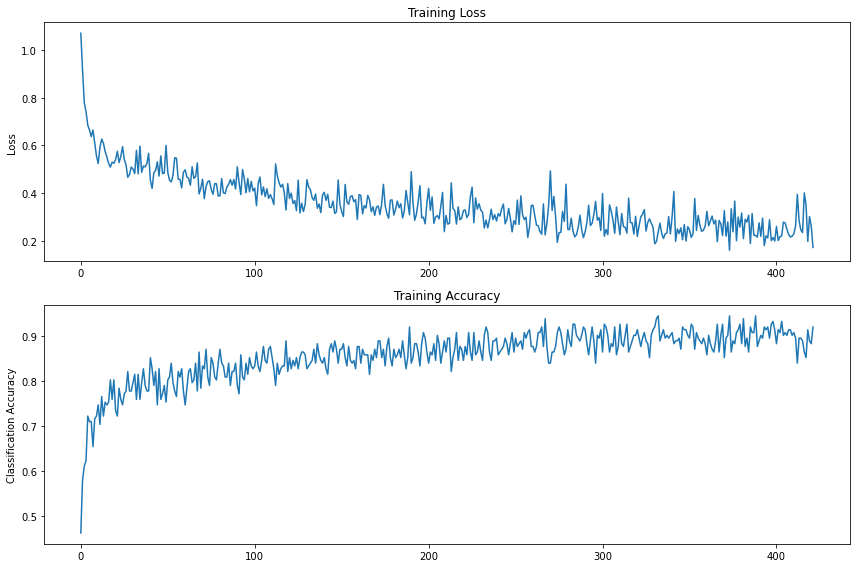

In [511]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

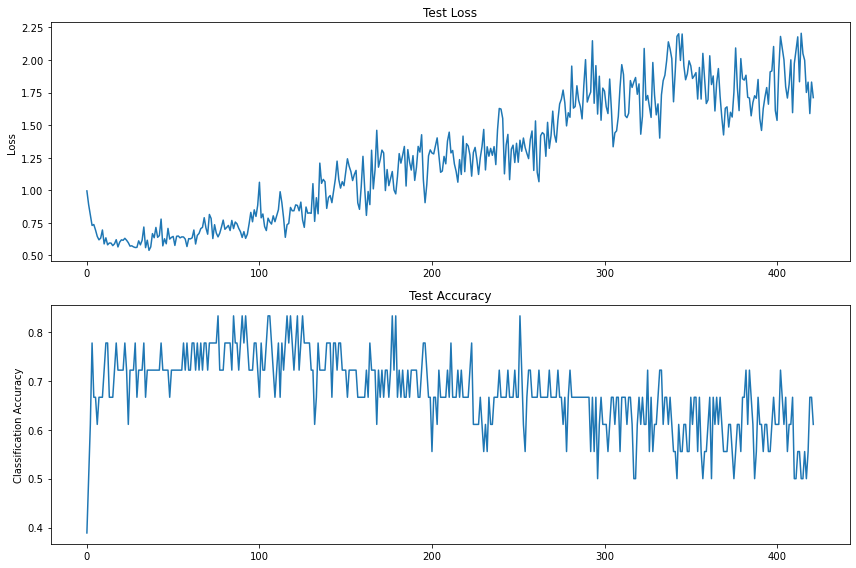

In [512]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(val_loss_list[:])
ax[0].set_ylabel('Loss')
ax[0].set_title('Test Loss')

ax[1].plot(val_corrects_list[:])
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

In [513]:
print("train:",np.array(train_accuracy[:]).mean())
print("test:",np.array(val_corrects_list[:]).mean())


train: 0.8567374641624246
test: 0.6783833596629807


0.15992603154370078

In [532]:
best_acc

0.23608738500624896

In [514]:
val_model = Conv1d_net_mod()
val_model.load_state_dict(torch.load(PATH))
val_model.eval()

Conv1d_net_mod(
  (conv1): Conv1d(1, 5, kernel_size=(2,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=45, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=3, bias=True)
  (drop_3): Dropout(p=0.3, inplace=False)
  (drop_4): Dropout(p=0.4, inplace=False)
  (conv1_bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [515]:
correct = 0
total = 0
test_loss = 0
outputs_list = []
y_list = []

with torch.no_grad():
    val_loss = 0

    for i, data in enumerate(task1_test_dataloader):
        x, y = data
        x, y = x.float(), y.long()
        outputs = val_model(x)
        loss = criterion(outputs, y)
        _, predicted = torch.max(outputs.data, 1)
        outputs_list.append(predicted[:])
        total += y.size(0)
        correct += (predicted == y).double().sum().item()
        val_loss += loss.item()
        y_list.append(y)

print('Accuracy of the test dataset is: %d %%' % (100 * correct / total))
print("Loss of validation set: {:.5f}".format((val_loss / test_size)))
acc = (100 * correct / total)

Accuracy of the test dataset is: 61 %
Loss of validation set: 0.26652


In [482]:
yields = torch.Tensor()
torch.cat(outputs_list, out=yields)
yields = yields.numpy()

In [78]:
targets = torch.Tensor()
torch.cat(y_list, out=targets)
targets = targets.numpy()

In [79]:
print(yields)
print(targets)
print((yields == targets))

[0. 0. 1. 0. 1. 0. 2. 2. 1. 1. 2. 2. 1. 1. 2. 2. 1. 1.]
[0. 0. 1. 0. 1. 0. 2. 2. 1. 1. 2. 2. 1. 1. 2. 2. 1. 1.]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
